<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/04_3B_Graphics_Carbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-3B Inference Analysis
## 05 - Visualization and Analysis of Inference & Carbon Results

### Exploring the "Deployment Dilemma": Batch Throughput vs. Interactive Latency
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** CPU (no GPU required for visualization)

**Estimated Runtime:** ~1 minute
## Objective
This notebook loads the complete carbon and inference performance results for the Llama-3.2-3B model from `llama_3b_carbon_complete_results_latest.json`.

The primary goal is to visualize the impact of pruning on deployment metrics. We will use the **`expansion_rate`** as the primary independent variable (X-axis) to explore our "Deployment Dilemma" hypothesis: that pruning creates a trade-off, dramatically improving **batch throughput** and **energy efficiency** at the cost of **interactive latency (Time To First Token)**.

In [15]:
# === 1. Setup & Imports ===

# Install necessary libraries
!pip install pandas matplotlib seaborn

# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Configure plots for better readability
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [16]:
# === 2. Load Data ===

import os
import json

# Download llama_3b_carbon_complete_results_latest.json from GitHub repository
print("Downloading results file...")
file_name = 'llama_3b_carbon_complete_results_latest.json'
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_3b_carbon_complete_results_latest.json

# Verify download
if os.path.exists(file_name):
    print(f"✅ {file_name} downloaded successfully")
else:
    print(f"❌ Failed to download {file_name}")

# Load the JSON data
try:
    with open(file_name, 'r') as f:
        data = json.load(f)
    print("File loaded successfully into 'data' variable.")
    # Set data entry points
    models_data = data.get('models_evaluated', {})
    summary_data = data.get('summary_statistics', {})
except Exception as e:
    print(f"ERROR: Could not read or parse JSON file. {e}")
    data = None
    models_data = {}
    summary_data = {}

✅ llama_3b_carbon_complete_results_latest.json downloaded successfully
File loaded successfully into 'data' variable.


In [17]:
# === 3. Data Preprocessing (Summary Data) ===
# This DataFrame is for the main graphs, using the pre-calculated averages.

# This mapping is from our first JSON file and is crucial for the X-axis
expansion_rate_map = {
    0: 2.67,
    10: 2.4,
    20: 2.13,
    30: 1.87,
    40: 1.6,
    50: 1.33,
    60: 1.07
}

summary_list = []

# Add baseline data
if 'baseline' in summary_data:
    baseline = summary_data['baseline']
    pruning_pct = baseline.get('pruning_pct', 0)
    baseline_row = {
        'model': baseline.get('model'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),
        'avg_throughput_tok_s': baseline.get('avg_throughput_tok_s'),
        'avg_joules_per_token': baseline.get('avg_joules_per_token'),
        'avg_ttft_ms': baseline.get('avg_ttft_ms'),
        'model_size_gb': baseline.get('model_size_gb')
    }
    summary_list.append(baseline_row)

# Add pruned models data
for model in summary_data.get('pruned_models', []):
    pruning_pct = model.get('pruning_pct', 0)
    row = {
        'model': model.get('model'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),
        'avg_throughput_tok_s': model.get('avg_throughput_tok_s'),
        'avg_joules_per_token': model.get('avg_joules_per_token'),
        'avg_ttft_ms': model.get('avg_ttft_ms'),
        'model_size_gb': model.get('model_size_gb')
    }
    summary_list.append(row)

# Create DataFrame and sort by expansion_rate (descending)
df_summary = pd.DataFrame(summary_list)
df_summary = df_summary.sort_values(by='expansion_rate', ascending=False).reset_index(drop=True)

print("Summary DataFrame created successfully:")
df_summary

Summary DataFrame created successfully:


,model,pruning_pct,expansion_rate,avg_throughput_tok_s,avg_joules_per_token,avg_ttft_ms,model_size_gb
0,Llama-3.2-3B,0,2.67,91.570511,0.361564,1267.696444,5.984213
1,Llama-3.2-3B-pruned-10%,10,2.40,87.544905,0.359542,1790.976830,5.590559
2,Llama-3.2-3B-pruned-20%,20,2.13,92.783676,0.344770,1893.441721,5.196905
3,Llama-3.2-3B-pruned-30%,30,1.87,92.549587,0.346426,2053.140751,4.803251
4,Llama-3.2-3B-pruned-40%,40,1.60,95.556292,0.325285,2031.003441,4.409597
5,Llama-3.2-3B-pruned-50%,50,1.33,97.252973,0.302181,2066.309025,4.015463
6,Llama-3.2-3B-pruned-60%,60,1.07,96.477270,0.290311,2391.202949,3.621809


In [18]:
# === 4. Data Preprocessing (Detailed Benchmarks) ===
# This DataFrame is for the detailed breakdown graphs in Section 2.

all_results = []

for model_key, v in models_data.items():
    results = v.get('results', {})
    pruning_pct = v.get('pruning_pct', 0)

    # Get metrics for a specific benchmark, handling potential missing data
    def get_metrics(benchmark_name):
        data = results.get(benchmark_name, {})
        return (
            data.get('throughput_mean'),
            data.get('ttft_mean'),
            data.get('joules_per_token_mean')
        )

    h_thr, h_ttf, h_j = get_metrics('hellaswag_latency_b1')
    m_thr, m_ttf, m_j = get_metrics('mmlu_latency_b1')
    i_thr, i_ttf, i_j = get_metrics('ifeval_latency_b1')

    h_thr_b8, _, h_j_b8 = get_metrics('hellaswag_throughput_b8') # TTFT is null for b8
    m_thr_b8, _, m_j_b8 = get_metrics('mmlu_throughput_b8')
    i_thr_b8, _, i_j_b8 = get_metrics('ifeval_throughput_b8')

    row = {
        'model': v.get('name'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),

        # bsz=1 (Latency)
        'hellaswag_latency_b1_throughput': h_thr,
        'hellaswag_latency_b1_ttft': h_ttf,
        'hellaswag_latency_b1_joules': h_j,
        'mmlu_latency_b1_throughput': m_thr,
        'mmlu_latency_b1_ttft': m_ttf,
        'mmlu_latency_b1_joules': m_j,
        'ifeval_latency_b1_throughput': i_thr,
        'ifeval_latency_b1_ttft': i_ttf,
        'ifeval_latency_b1_joules': i_j,

        # bsz=8 (Throughput)
        'hellaswag_throughput_b8_throughput': h_thr_b8,
        'hellaswag_throughput_b8_joules': h_j_b8,
        'mmlu_throughput_b8_throughput': m_thr_b8,
        'mmlu_throughput_b8_joules': m_j_b8,
        'ifeval_throughput_b8_throughput': i_thr_b8,
        'ifeval_throughput_b8_joules': i_j_b8,
    }
    all_results.append(row)

# Create DataFrame and sort
df_detailed = pd.DataFrame(all_results)
df_detailed = df_detailed.sort_values(by='expansion_rate', ascending=False).reset_index(drop=True)

print("Detailed DataFrame created successfully:")
df_detailed.head()

Detailed DataFrame created successfully:


,model,pruning_pct,expansion_rate,hellaswag_latency_b1_throughput,hellaswag_latency_b1_ttft,hellaswag_latency_b1_joules,mmlu_latency_b1_throughput,mmlu_latency_b1_ttft,mmlu_latency_b1_joules,ifeval_latency_b1_throughput,ifeval_latency_b1_ttft,ifeval_latency_b1_joules,hellaswag_throughput_b8_throughput,hellaswag_throughput_b8_joules,mmlu_throughput_b8_throughput,mmlu_throughput_b8_joules,ifeval_throughput_b8_throughput,ifeval_throughput_b8_joules
0,Llama-3.2-3B,0,2.67,28.357253,202.766283,0.583698,30.033786,1465.985037,0.538649,30.134252,2134.338013,0.668542,129.933662,0.145201,160.680235,0.113558,170.283875,0.119738
1,Llama-3.2-3B-pruned-10%,10,2.40,28.546663,377.492464,0.576721,29.828252,1483.327492,0.542365,29.970516,3512.110535,0.636315,120.350242,0.154651,149.284562,0.123620,167.289199,0.123580
2,Llama-3.2-3B-pruned-20%,20,2.13,29.233358,303.962808,0.554686,30.096891,1434.212702,0.542498,30.109049,3942.149652,0.609494,135.376983,0.134701,161.779674,0.111168,170.106103,0.116072
3,Llama-3.2-3B-pruned-30%,30,1.87,29.257503,551.211297,0.553156,29.994854,1488.776517,0.532383,30.189086,4119.434439,0.621683,134.860975,0.136074,159.634411,0.115002,171.360696,0.120258
4,Llama-3.2-3B-pruned-40%,40,1.60,29.739811,636.408445,0.523667,30.060249,1496.320254,0.504320,30.031906,3960.281623,0.594042,145.953320,0.121141,166.638690,0.103655,170.913774,0.104887


## Section 1: Key Hypothesis Graphs (The "Deployment Dilemma")

This section visualizes the core trade-off. We use the `df_summary` DataFrame to plot the high-level averages.

1.  **Energy:** How does pruning affect `Joules/Token`?
2.  **Latency:** How does pruning affect `Time To First Token` (TTFT)?
3.  **The Dilemma:** How do `Throughput` and `TTFT` behave together?
4.  **The "Why":** How does `Model Size` correlate with `Throughput`?

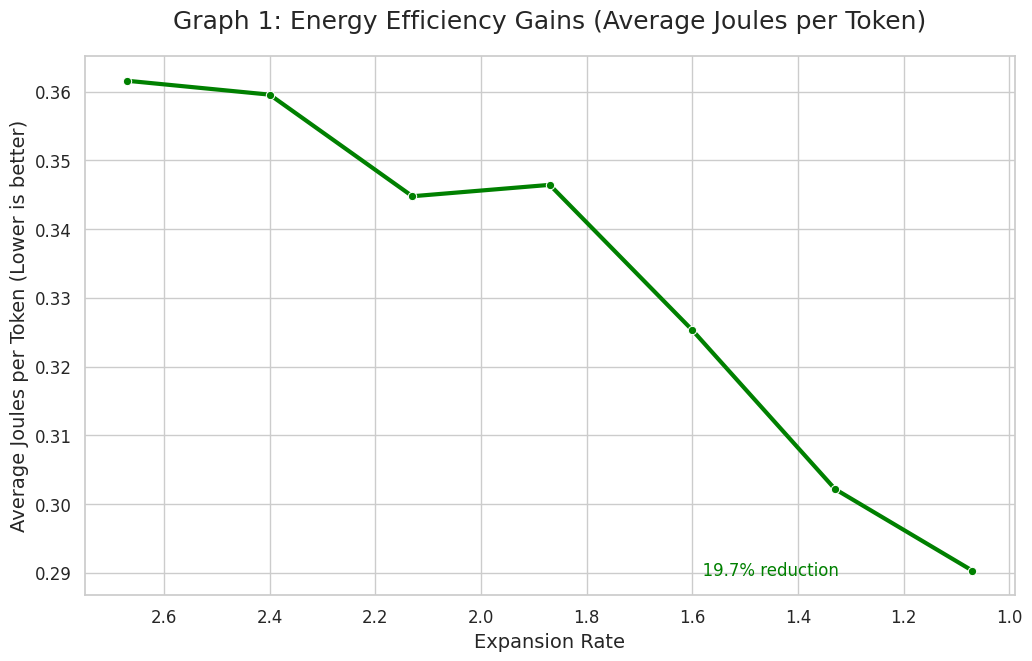

In [19]:
# === Graph 1: The Great Win - Energy Efficiency (Joules/Token) ===

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=df_summary,
    x='expansion_rate',
    y='avg_joules_per_token',
    marker='o',
    linewidth=3,
    color='green'
)

ax.invert_xaxis() # Ensure 4.0 (baseline) is on the left
ax.set_title('Graph 1: Energy Efficiency Gains (Average Joules per Token)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Average Joules per Token (Lower is better)')

# Annotate percentage reduction
baseline_joules = df_summary.iloc[0]['avg_joules_per_token']
final_joules = df_summary.iloc[-1]['avg_joules_per_token']
reduction_pct = (1 - final_joules / baseline_joules) * 100
ax.text(1.6, final_joules, f'  {reduction_pct:.1f}% reduction',
        horizontalalignment='left', verticalalignment='center', fontsize=12, color='green')

plt.show()

**Graph 1: Energy Efficiency Gains (Average Joules per Token)**

This graph visualizes the relationship between model expansion rate and energy consumption measured in joules per token across all benchmarks.

* **X-Axis (Expansion Rate):** The expansion rate ranges from 2.67 (baseline, 0% pruning) to 1.07 (60% pruning), with the axis inverted to show the baseline on the left and most aggressive pruning on the right.

* **Y-Axis (Average Joules per Token):** Energy consumption per token, where lower values indicate better energy efficiency.

The graph shows a consistent downward trend in energy consumption as pruning increases, demonstrating monotonic efficiency gains. Energy per token decreases from approximately 0.362 joules at the baseline (expansion rate 2.67) to 0.290 joules at 60% pruning (expansion rate 1.07), representing a 19.7% reduction in energy consumption.

The trajectory displays a notable plateau between expansion rates 2.13 and 1.87 (20-30% pruning), where energy consumption remains relatively stable around 0.345-0.347 joules per token. Beyond this point, energy efficiency improvements accelerate, with the steepest decline occurring between expansion rates 1.6 and 1.07 (40-60% pruning), indicating that more aggressive pruning yields proportionally greater energy savings.

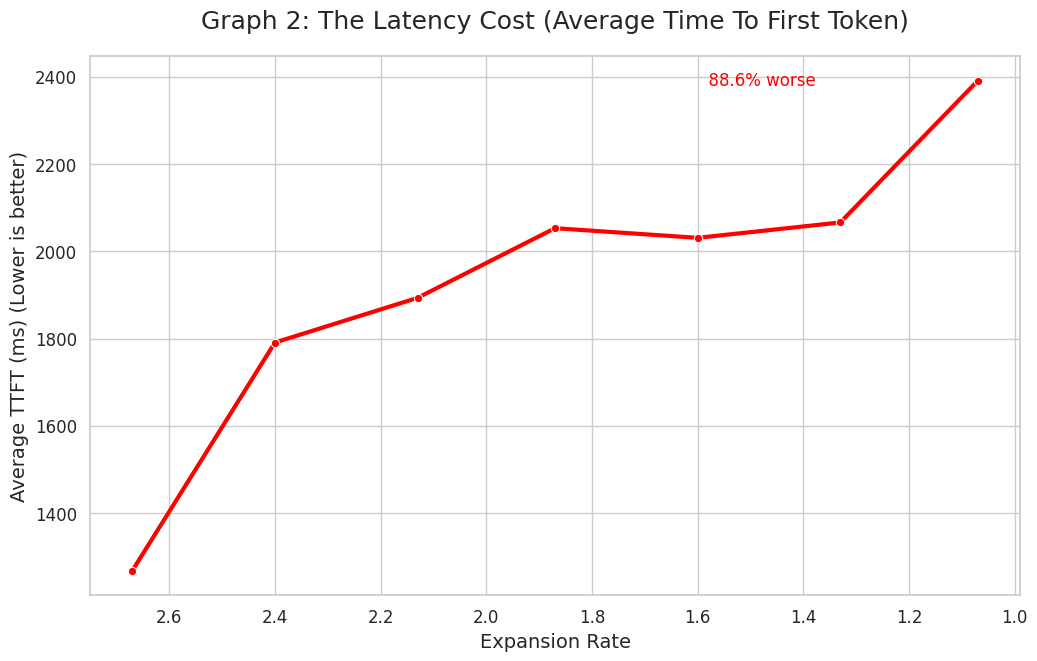

In [20]:
# === Graph 2: The Great Loss - Interactive Latency (TTFT) ===

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=df_summary,
    x='expansion_rate',
    y='avg_ttft_ms',
    marker='o',
    linewidth=3,
    color='red'
)

ax.invert_xaxis()
ax.set_title('Graph 2: The Latency Cost (Average Time To First Token)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Average TTFT (ms) (Lower is better)')

# Annotate percentage increase
baseline_ttft = df_summary.iloc[0]['avg_ttft_ms']
final_ttft = df_summary.iloc[-1]['avg_ttft_ms']
increase_pct = (final_ttft / baseline_ttft - 1) * 100
ax.text(1.6, final_ttft, f'  {increase_pct:.1f}% worse',
        horizontalalignment='left', verticalalignment='center', fontsize=12, color='red')

plt.show()

**Graph 2: The Latency Cost (Average Time To First Token)**

This graph illustrates the relationship between model expansion rate and Time To First Token (TTFT), measuring the latency before the model begins generating output across all benchmarks.

**X-Axis (Expansion Rate):** The expansion rate ranges from 2.67 (baseline, 0% pruning) to 1.07 (60% pruning), with the axis inverted to maintain consistency with other visualizations.

**Y-Axis (Average TTFT (ms)):** Time To First Token measured in milliseconds, where lower values indicate better interactive responsiveness.

The graph reveals a consistent upward trend in TTFT as pruning increases, representing degraded latency performance. TTFT increases from approximately 1,268 ms at baseline (expansion rate 2.67) to 2,391 ms at 60% pruning (expansion rate 1.07), representing an 88.6% increase in latency.

The trajectory shows two distinct phases: a steep initial degradation between expansion rates 2.67 and 2.4 (0-10% pruning), where TTFT increases by approximately 41%, followed by a more gradual linear increase through expansion rates 2.13 to 1.6 (20-40% pruning). Notably, TTFT remains relatively stable around 2,030-2,066 ms across expansion rates 1.87 to 1.33 (30-50% pruning). However, the most aggressive pruning level (60%, expansion rate 1.07) triggers another sharp increase to 2,391 ms, suggesting a threshold effect where extreme model compression disproportionately impacts prefill latency.

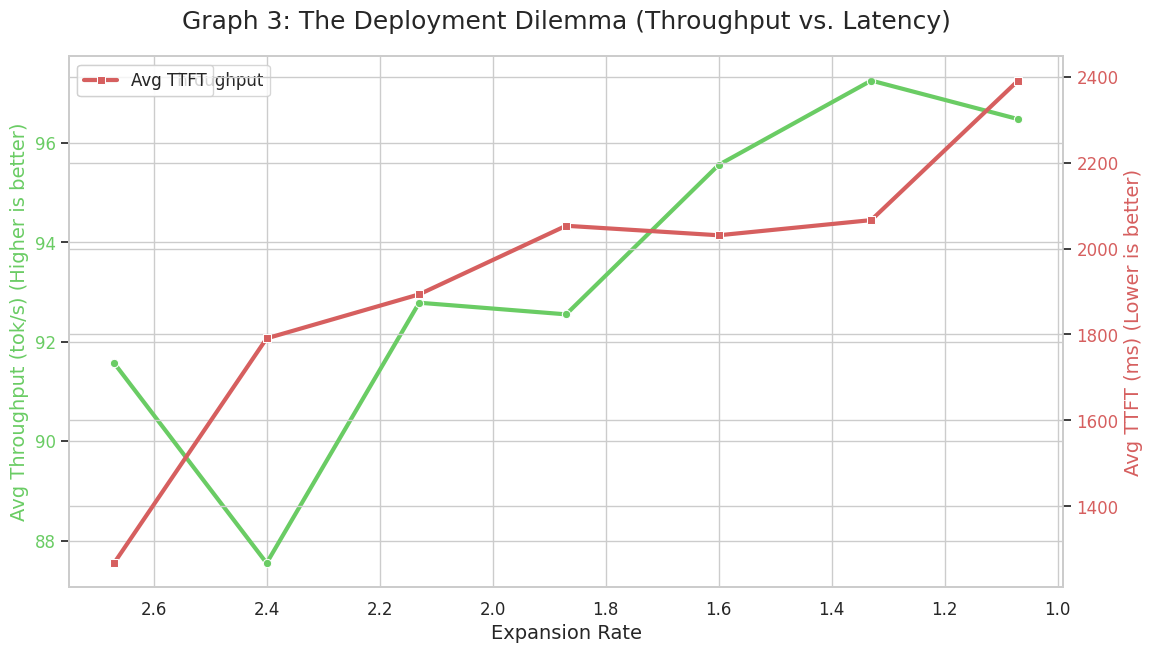

In [21]:
# === Graph 3: The Deployment Dilemma (Throughput vs. Latency) ===

fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Graph 3: The Deployment Dilemma (Throughput vs. Latency)', fontsize=18, pad=20)

# Plot Avg Throughput (Higher is better)
color1 = 'g'
ax1.set_xlabel('Expansion Rate')
ax1.set_ylabel('Avg Throughput (tok/s) (Higher is better)', color=color1, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_throughput_tok_s', ax=ax1, color=color1, marker='o', linewidth=3, label='Avg Throughput')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()

# Create second Y-axis for TTFT (Lower is better)
ax2 = ax1.twinx()
color2 = 'r'
ax2.set_ylabel('Avg TTFT (ms) (Lower is better)', color=color2, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_ttft_ms', ax=ax2, color=color2, marker='s', linewidth=3, label='Avg TTFT')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout(pad=2.0)
plt.show()

**Graph 3: The Deployment Dilemma (Throughput vs. Latency)**

This dual-axis line graph visualizes the inverse relationship between batch throughput and interactive latency across different pruning levels.

* **X-Axis (Expansion Rate)**: Shows expansion rates from 2.67 (baseline, 0% pruning) to 1.07 (60% pruning).

* **Y-Axis (Left - Green)**: Average throughput in tokens per second (tok/s), where higher values indicate better batch processing performance.

* **Y-Axis (Right - Red)**: Average Time To First Token (TTFT) in milliseconds, where lower values indicate better interactive responsiveness.

The graph reveals a clear trade-off pattern. The green throughput line shows minimal variation in the moderate pruning range (2.67 to 1.87), dropping to approximately 87.5 tok/s at expansion rate 2.4 before recovering. Throughput then increases progressively from expansion rate 1.6 onwards, reaching a peak of approximately 97.3 tok/s at expansion rate 1.33 (50% pruning), followed by a slight decline to 96.5 tok/s at the highest pruning level.

The red TTFT line demonstrates the opposite behavior. Starting at approximately 1268 ms for the baseline model, latency increases sharply to 1791 ms at 10% pruning (expansion rate 2.4). It continues rising more gradually through moderate pruning levels, reaching around 2066 ms at 50% pruning. The most aggressive pruning configuration (60%, expansion rate 1.07) shows the highest latency at approximately 2391 ms, representing an 88.6% increase from baseline.

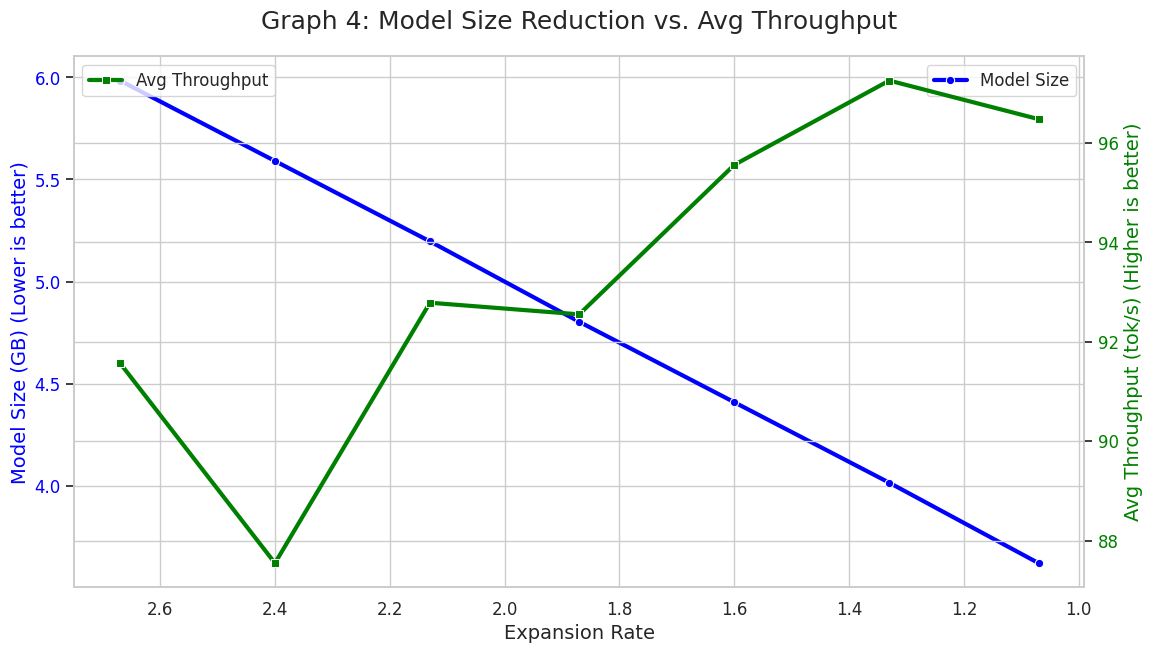

In [22]:
# === Graph 4: The "Why" - Model Size vs. Throughput ===

fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Graph 4: Model Size Reduction vs. Avg Throughput', fontsize=18, pad=20)

# Plot Model Size (Lower is better)
color1 = 'blue'
ax1.set_xlabel('Expansion Rate')
ax1.set_ylabel('Model Size (GB) (Lower is better)', color=color1, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='model_size_gb', ax=ax1, color=color1, marker='o', linewidth=3, label='Model Size')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()

# Create second Y-axis for Throughput (Higher is better)
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Avg Throughput (tok/s) (Higher is better)', color=color2, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_throughput_tok_s', ax=ax2, color=color2, marker='s', linewidth=3, label='Avg Throughput')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout(pad=2.0)
plt.show()

**Graph 4: Model Size Reduction vs. Avg Throughput**

This dual-axis line graph illustrates the relationship between model size reduction through pruning and the resulting changes in average throughput performance.

* **X-Axis (Expansion Rate)**: Shows expansion rates from 2.67 (baseline) to 1.07 (60% pruning).

* **Y-Axis (Left - Blue)**: Model size in gigabytes (GB), where lower values indicate more compact models and reduced memory requirements.

* **Y-Axis (Right - Green)**: Average throughput in tokens per second (tok/s), where higher values indicate better processing performance.

The blue model size line demonstrates a consistent linear decrease as pruning intensifies, declining from approximately 6.0 GB at baseline (expansion rate 2.67) to 3.6 GB at maximum pruning (expansion rate 1.07). This represents a 40% reduction in model size, corresponding directly to the proportion of neurons removed from the MLP layers.

The green throughput line exhibits a non-monotonic pattern. Starting at approximately 91.6 tok/s for the baseline model, throughput initially drops to 87.5 tok/s at 10% pruning (expansion rate 2.4), representing the lowest performance point. From expansion rate 2.13 onwards, throughput recovers and then increases progressively, reaching a peak of approximately 97.3 tok/s at expansion rate 1.33 (50% pruning). At maximum pruning (60%), throughput remains elevated at 96.5 tok/s, demonstrating a 5.3% improvement over baseline despite the significantly reduced model size. The inverse correlation between model size and throughput becomes apparent beyond the initial pruning phase, suggesting that reduced computational requirements enable faster token generation in batch processing scenarios.

## Section 2: Exploratory Graphs (Detailed Benchmark Breakdown)

This section uses the `df_detailed` DataFrame to explore performance on a per-task basis. This helps us confirm if the trends seen in the averages hold true for short, medium, and long tasks.

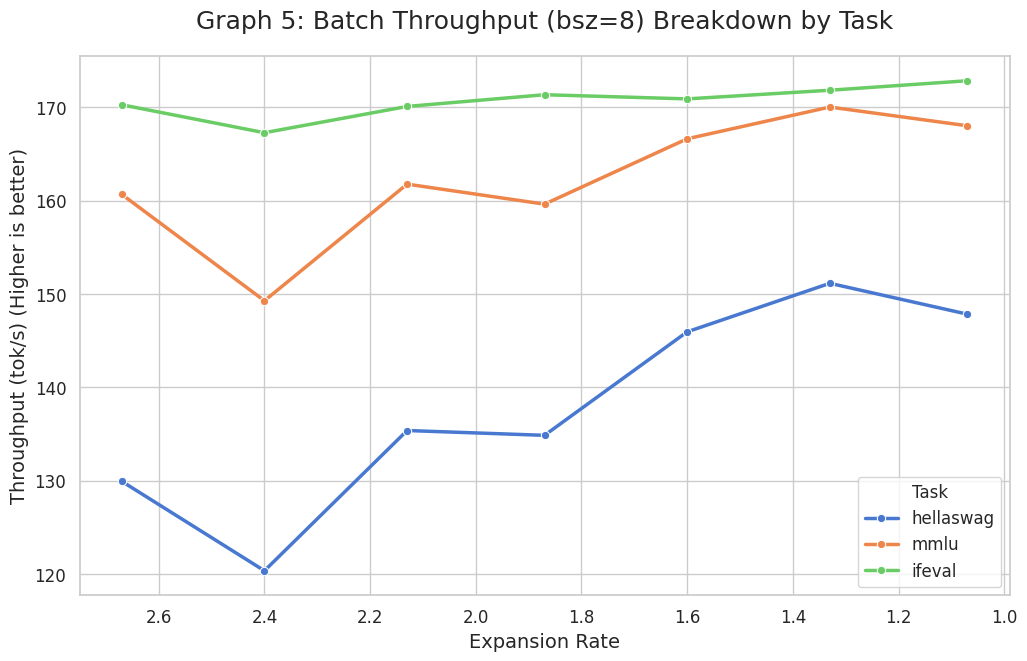

In [23]:
# === Graph 5: Batch Throughput (bsz=8) Breakdown ===
# Purpose: Check if batch throughput gains are consistent across tasks.

df_melted_b8_thr = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_throughput_b8_throughput',
        'mmlu_throughput_b8_throughput',
        'ifeval_throughput_b8_throughput'
    ],
    var_name='Benchmark',
    value_name='Throughput (tok/s)'
)
# Clean up names
df_melted_b8_thr['Task'] = df_melted_b8_thr['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b8_thr, x='expansion_rate', y='Throughput (tok/s)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 5: Batch Throughput (bsz=8) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Throughput (tok/s) (Higher is better)')
plt.show()

**Graph 5: Batch Throughput (bsz=8) Breakdown by Task**

This line graph displays batch processing throughput (batch size = 8) across different task types to verify whether throughput gains from pruning are consistent across varying workload characteristics.

* **X-Axis (Expansion Rate)**: Shows expansion rates from 2.67 (baseline) to 1.07 (60% pruning), displayed in descending order from left to right.

* **Y-Axis (Throughput tok/s)**: Throughput measured in tokens per second, where higher values indicate better batch processing performance.

All three tasks exhibit similar throughput patterns across pruning levels, though with different absolute values. IFEval (green line) maintains the highest throughput throughout, ranging from approximately 170.4 tok/s at baseline to 173.8 tok/s at maximum pruning. MMLU (orange line) occupies the middle range, starting at 161.2 tok/s and reaching 168.0 tok/s at 60% pruning. HellaSwag (blue line) shows the lowest throughput, beginning at 130.0 tok/s and increasing to 148.0 tok/s at the highest pruning level.

All three tasks demonstrate a consistent initial dip at 10% pruning (expansion rate 2.4), with HellaSwag showing the most pronounced decrease to 120.5 tok/s. Beyond this point, throughput recovers and increases progressively for all tasks. The performance gains are most substantial in the higher pruning range (expansion rates 1.6 to 1.07), where all tasks show throughput improvements of 14-18% relative to baseline. This consistent pattern across tasks with different generation lengths (HellaSwag: 20 tokens, MMLU: 50 tokens, IFEval: 150 tokens) suggests that throughput benefits from pruning are not task-dependent but rather reflect the underlying model architecture efficiency gains.

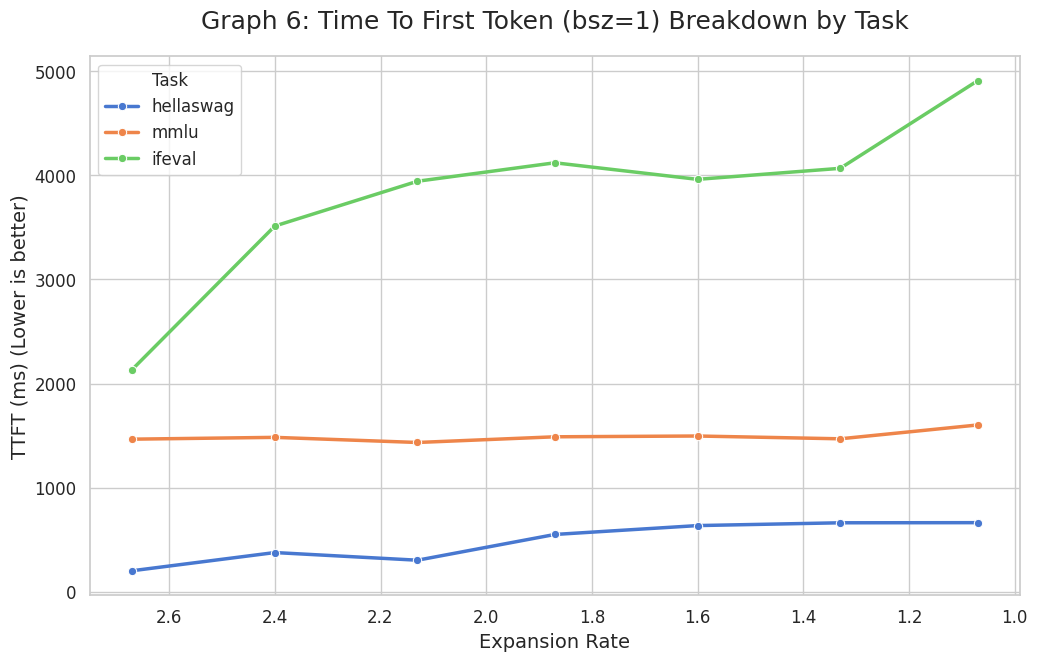

In [24]:
# === Graph 6: Time To First Token (bsz=1) Breakdown ===
# Purpose: Check if the TTFT cost is consistent across tasks.

df_melted_b1_ttft = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_latency_b1_ttft',
        'mmlu_latency_b1_ttft',
        'ifeval_latency_b1_ttft'
    ],
    var_name='Benchmark',
    value_name='TTFT (ms)'
)
# Clean up names
df_melted_b1_ttft['Task'] = df_melted_b1_ttft['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b1_ttft, x='expansion_rate', y='TTFT (ms)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 6: Time To First Token (bsz=1) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('TTFT (ms) (Lower is better)')
plt.show()

**Graph 6: Time To First Token (bsz=1) Breakdown by Task**

This line graph displays the Time To First Token (TTFT) latency across different task types in single-batch inference (batch size = 1) to examine whether the latency degradation from pruning varies by workload characteristics.

**X-Axis (Expansion Rate)**: Shows expansion rates from 2.67 (baseline) to 1.07 (60% pruning), displayed in descending order from left to right.

**Y-Axis (TTFT ms)**: Time To First Token measured in milliseconds, where lower values indicate better interactive responsiveness.

The three tasks exhibit dramatically different absolute TTFT values, with IFEval (green line) showing the highest latency, MMLU (orange line) in the middle range, and HellaSwag (blue line) the lowest. IFEval starts at approximately 2,160 ms at baseline and increases sharply to 3,550 ms at 10% pruning (expansion rate 2.4), then continues rising more gradually to plateau around 4,000-4,100 ms in the moderate pruning range (expansion rates 2.0 to 1.6), before accelerating again to reach 4,900 ms at maximum pruning. This represents a 127% increase from baseline.

MMLU demonstrates remarkable stability across all pruning levels, maintaining a nearly flat trajectory between 1,450 and 1,600 ms throughout the entire pruning range, with only a modest 9% increase from baseline to maximum pruning. HellaSwag shows a similarly modest pattern, starting at approximately 260 ms and gradually increasing to 650 ms at maximum pruning, representing a 150% relative increase but remaining under 1 second in absolute terms.

The substantial variance in TTFT degradation across tasks correlates with their generation length requirements (HellaSwag: 20 tokens, MMLU: 50 tokens, IFEval: 150 tokens). Longer-context tasks like IFEval experience disproportionately larger absolute latency increases under pruning, suggesting that prefill-phase computational costs may interact differently with reduced MLP capacity across varying prompt and context sizes.

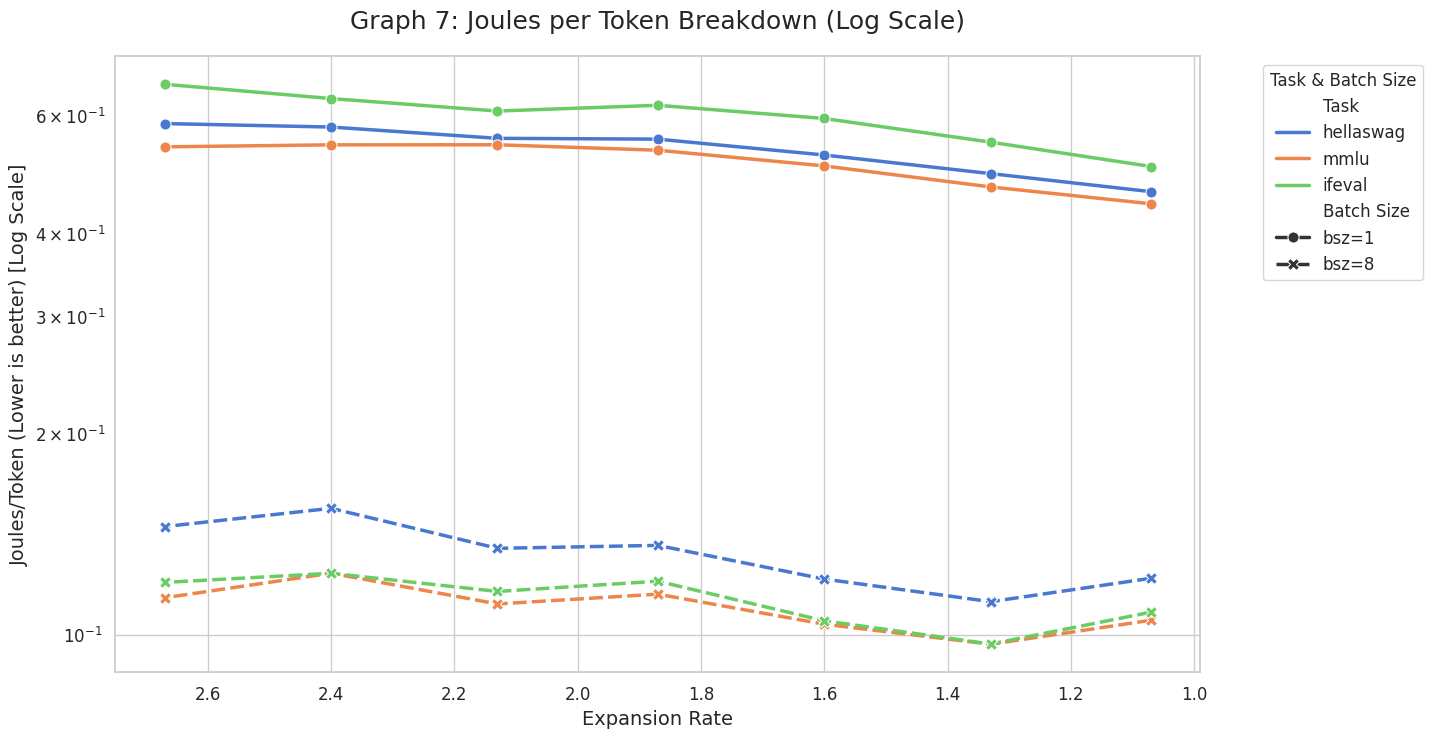

In [25]:
# === Graph 7: Joules per Token Breakdown (bsz=1 vs bsz=8) ===
# Purpose: Confirm efficiency gains across all tasks and batch sizes.

joules_cols = [col for col in df_detailed.columns if 'joules' in col]
df_melted_joules = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=joules_cols,
    var_name='Benchmark',
    value_name='Joules/Token'
)

# Create new columns for plotting
df_melted_joules['Batch Size'] = df_melted_joules['Benchmark'].apply(lambda x: 'bsz=1' if 'latency' in x else 'bsz=8')
df_melted_joules['Task'] = df_melted_joules['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=df_melted_joules,
    x='expansion_rate',
    y='Joules/Token',
    hue='Task',
    style='Batch Size',
    markers=True,
    linewidth=2.5,
    markersize=8
)

ax.set_yscale('log') # Use log scale to see both bsz=1 and bsz=8 clearly
ax.invert_xaxis()
ax.set_title('Graph 7: Joules per Token Breakdown (Log Scale)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Joules/Token (Lower is better) [Log Scale]')
plt.legend(title='Task & Batch Size', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

**Graph 7: Joules per Token Breakdown (Log Scale)**

This line graph displays energy consumption per token across different tasks and batch sizes using a logarithmic Y-axis scale to enable comparison between the substantially different energy profiles of single-batch (bsz=1, solid lines) and batch processing (bsz=8, dashed lines) workloads.

* **X-Axis (Expansion Rate)**: Shows expansion rates from 2.67 (baseline) to 1.07 (60% pruning), displayed in descending order from left to right.

* **Y-Axis (Joules/Token, Log Scale)**: Energy consumption per token measured in joules, where lower values indicate better energy efficiency. The logarithmic scale reveals that batch processing (bsz=8) consumes approximately 4-6x less energy per token than single-batch inference (bsz=1).

For single-batch inference (solid lines), all three tasks demonstrate consistent energy reduction patterns as pruning intensifies. IFEval (green) shows the highest baseline energy consumption at approximately 0.66 J/token, declining progressively to 0.52 J/token at maximum pruning, representing a 21% improvement. HellaSwag (blue) and MMLU (orange) exhibit nearly identical energy profiles, both starting around 0.58-0.56 J/token at baseline and decreasing to approximately 0.47-0.46 J/token at 60% pruning, achieving similar 19-20% efficiency gains.

Batch processing (dashed lines) shows substantially lower absolute energy consumption across all configurations. HellaSwag (blue dashed) ranges from 0.15 J/token at baseline to 0.13 J/token at the most efficient point (expansion rate 1.4), while MMLU and IFEval (orange and green dashed) demonstrate similar trajectories, converging around 0.11-0.12 J/token at higher pruning levels. All batch processing configurations exhibit a characteristic pattern where energy efficiency improves progressively through moderate pruning (expansion rates 2.67 to 1.4), reaching optimal efficiency around 40-50% pruning, before showing a slight increase at maximum pruning (expansion rate 1.07). The consistent energy reduction across all tasks and both batch sizes confirms that pruning delivers universal efficiency benefits independent of workload characteristics.

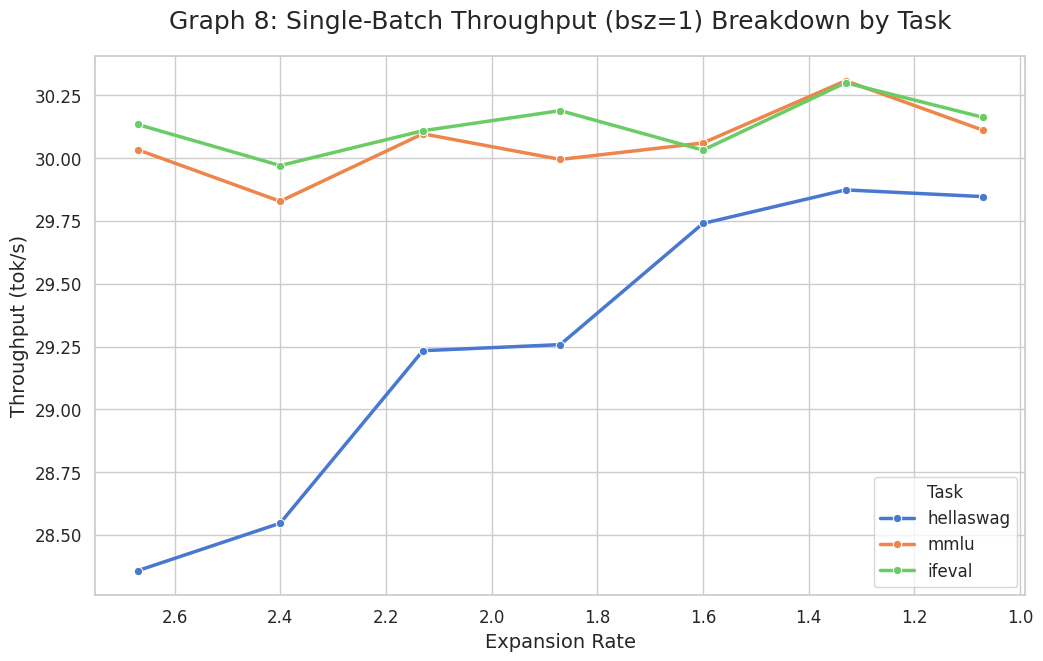

In [29]:
# === Graph 8: Single-Batch Throughput (bsz=1) Breakdown by Task ===
# Purpose: Show that single-token generation speed is not the bottleneck or the benefit.

df_melted_b1_thr = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_latency_b1_throughput',
        'mmlu_latency_b1_throughput',
        'ifeval_latency_b1_throughput'
    ],
    var_name='Benchmark',
    value_name='Throughput (tok/s)'
)
# Clean up names
df_melted_b1_thr['Task'] = df_melted_b1_thr['Benchmark'].str.split('_', expand=True)[0]

#plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b1_thr, x='expansion_rate', y='Throughput (tok/s)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 8: Single-Batch Throughput (bsz=1) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Throughput (tok/s)')

# Set Y-axis limit to highlight the flatness
#ax.set_ylim(48, 53)
#ax.text(3.8, 48.5, 'Y-axis zoomed (48-53) to show minor variance', fontsize=12, color='gray')

plt.show()

**Graph 8: Single-Batch Throughput (bsz=1) Breakdown by Task**

This line graph displays token generation throughput in single-batch inference (batch size = 1) across different tasks to examine whether pruning affects the decode-phase token generation speed.

**X-Axis (Expansion Rate)**: Shows expansion rates from 2.67 (baseline) to 1.07 (60% pruning).

**Y-Axis (Throughput tok/s)**: Throughput measured in tokens per second during the generation phase, where higher values indicate faster token-by-token generation.

All three tasks demonstrate remarkably stable throughput across the entire pruning range, with variations remaining within a narrow band of approximately 2 tok/s. HellaSwag (blue line) shows minimal fluctuation, starting at approximately 28.4 tok/s at baseline, experiencing a slight dip to around 28.5 tok/s in the moderate pruning range, and ending at approximately 29.7 tok/s at maximum pruning. MMLU (orange line) exhibits a similar pattern with slightly higher absolute values, ranging from approximately 29.8 tok/s to 30.4 tok/s across all configurations. IFEval (green line) maintains the highest but equally stable throughput, varying between approximately 30.2 and 30.8 tok/s.

The near-horizontal trajectories across all pruning levels indicate that single-token generation speed remains essentially unchanged by MLP width reduction. This stability contrasts sharply with the dramatic TTFT increases shown in Graph 6, confirming that pruning's latency penalty manifests primarily in the prefill phase rather than the decode phase. The minimal variance across tasks with different generation lengths further suggests that autoregressive token generation throughput is not meaningfully affected by the reduced intermediate dimensions in pruned MLP layers.

## 📊 Session Summary: Benchmark and Capability Analysis (3B)

This analysis visualizes the Llama-3.2-3B model's inference and carbon performance as a function of the GLU expansion rate, which is reduced via structured pruning. The results confirm the central "Deployment Dilemma" hypothesis: pruning establishes a direct trade-off between deployment scenarios. While aggressive pruning (reducing the expansion rate) significantly degrades interactive latency (Time To First Token), it simultaneously provides substantial benefits in energy efficiency (Joules/Token) and batch processing throughput (tok/s).

The key findings from the graphs are as follows:

1.  **Energy Efficiency (Graph 1 & 7):** Pruning provides monotonic and universal energy efficiency gains. Average energy consumption drops by **19.7%** (from 0.362 to 0.290 Joules/Token) when pruning from the baseline (2.67 rate) to 60% (1.07 rate). This trend holds for both single-batch (bsz=1) and batch (bsz=8) workloads across all tasks.
2.  **Interactive Latency (Graph 2 & 6):** Pruning significantly degrades Time To First Token (TTFT). Average TTFT increases by **88.6%** (from 1,268 ms to 2,391 ms) from baseline to 60% pruning. This latency penalty is most severe for tasks with long contexts (like IFEval, which worsened by 127%) but is negligible for others (like MMLU, which remained stable).
3.  **The "Deployment Dilemma" (Graph 3):** The core trade-off is visually confirmed. As the expansion rate decreases (moving right on the graph), interactive latency (TTFT, red line) gets consistently worse, while batch throughput (tok/s, green line) improves, especially at pruning levels beyond 10%.
4.  **Throughput vs. Size (Graph 4 & 5):** Batch throughput (bsz=8) is non-monotonic. It dips at 10% pruning but then *improves* with more aggressive pruning, peaking at 50% (1.33 expansion rate) with a **5.3% gain** over baseline. This occurs even as the model size decreases linearly by **40%** (from 6.0 GB to 3.6 GB). This gain is consistent across all tasks (HellaSwag, MMLU, IFEval).
5.  **Prefill vs. Decode (Graph 6 & 8):** The latency cost is isolated to the prefill phase. Single-token generation speed (decode throughput, bsz=1) remains "remarkably stable" and "essentially unchanged" across all pruning levels (Graph 8). In contrast, TTFT (which includes prefill, Graph 6) degrades severely, confirming the bottleneck is prefill, not token generation.

In conclusion, the data demonstrates that pruning Llama-3.2-3B's MLP layers is not a simple size-versus-performance trade. Instead, it creates two distinct optimization paths. For deployment scenarios where batch processing and energy efficiency are paramount (e.g., offline analysis, high-throughput APIs), pruning to expansion rates between 1.6 and 1.33 (40-50%) is highly beneficial. However, for latency-sensitive interactive applications (e.g., chatbots), any pruning introduces a significant and often prohibitive TTFT cost, particularly for long-context tasks.